<a href="https://colab.research.google.com/github/pratikiiitb2013/EVA4/blob/master/Session11/EVA4S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Mounting Drive***

<hr>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
import sys
print(sys.path)

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/EVA4/py_files_sid/'
path_models = '/content/gdrive/My Drive/Colab Notebooks/EVA4/py_files_sid/models/'
sys.path.append(path)
sys.path.append(path_models)

***Loading the python files from drive***


In [4]:
# !pip install torch-lr-finder
!pip install -U albumentations
from imports_eva import *
import data_loaders as dl                         # Loading CIFAR10 data into train/test dataloaders
# import model_file as mfile                        # ResNet18 Model architecture
import train_test_functions as ttfunc             # Model training and validation functions
import test_performance as tperform               # Class wise model accuracy and confusion matrix plot
import model_plots as mp                          # Plotting the Train/Test plots for loss and accuracy
import resnet_modified_A11 as mdl
import misclassified                              # Display misclassified images by the trained model
from scheduler import *
from cyclic_lr import *

     |████████████████████████████████| 122kB 30.9MB/s 
     |████████████████████████████████| 634kB 41.6MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=3b440e0b0f1cd3ded134439dce954d9439aa5f56aaa0fa7d5270abdf59628c44
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=da75182651a611c73c62c3b4c08826a98790d7bd842aa3d2a1468da84db4be16
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


***Loading CIFAR data and creating test/train loaders with augumentations***
<hr>

In [5]:
trainloader, testloader = dl.train_test_loaders()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


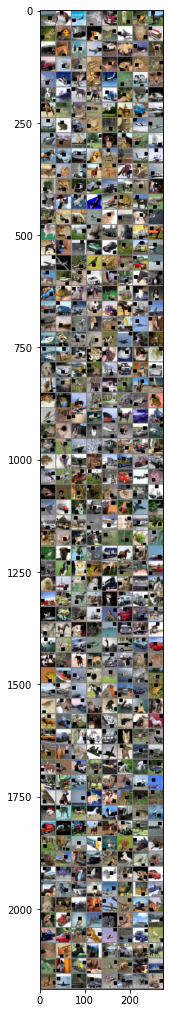

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(28,18))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

***Define the final target classes in CIFAR***


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

***Load Custom A11 model and print summary***
<hr>

In [8]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = mdl.resnet_modified_A11().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         Dropout2d-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
         Dropout2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
        Dropout2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
       BasicBlock-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

***Plotting cyclic LR found through code***
<hr>

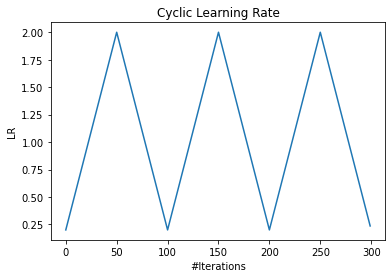

In [9]:
lrplt = LRCyclePlot({})
lrplt()

***Running for 20 Epochs with lenearly increasing LR to find max_lr for OCP***
<hr>

In [10]:
EPOCHS = 20

# lrs = np.logspace(-4, 0, EPOCHS)
lrs = np.linspace(1e-4, 1, EPOCHS)
mtms = np.linspace(0.9, 0.9, EPOCHS)
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001)
scheduler = ListScheduler(optimizer, lrs=lrs, momentums=mtms)


for epoch in range(EPOCHS):
    model = mdl.resnet_modified_A11().to(device)
    print("EPOCH:", epoch+1)
    current_lr = [g['lr'] for g in optimizer.param_groups]
    current_m = [g['momentum'] for g in optimizer.param_groups]
    print('LR: {}, M : {}'.format(current_lr, current_m))
    ta, tl, ta_epoch, tl_epoch   =  ttfunc.train(model, device, trainloader, optimizer, epoch)
    ta1, tl1 =  ttfunc.test(model, device, testloader, classes)
    scheduler.step()
    print('')


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1
LR: [0.0001], M : [0.0]


Loss=3.2497565746307373 Batch_id=97 Accuracy=8.13: 100%|██████████| 98/98 [00:22<00:00,  4.29it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 868/10000 (8.68%)


EPOCH: 2
LR: [0.05272631578947369], M : [0.0]


Loss=3.0147082805633545 Batch_id=97 Accuracy=11.86: 100%|██████████| 98/98 [00:22<00:00,  4.29it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 1183/10000 (11.83%)


EPOCH: 3
LR: [0.10535263157894736], M : [0.0]


Loss=3.272555112838745 Batch_id=97 Accuracy=10.76: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 1027/10000 (10.27%)


EPOCH: 4
LR: [0.15797894736842105], M : [0.0]


Loss=3.7407114505767822 Batch_id=97 Accuracy=9.75: 100%|██████████| 98/98 [00:23<00:00,  4.18it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 951/10000 (9.51%)


EPOCH: 5
LR: [0.21060526315789474], M : [0.0]


Loss=2.9685771465301514 Batch_id=97 Accuracy=10.09: 100%|██████████| 98/98 [00:23<00:00,  4.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 1003/10000 (10.03%)


EPOCH: 6
LR: [0.2632315789473684], M : [0.0]


Loss=3.1878154277801514 Batch_id=97 Accuracy=10.85: 100%|██████████| 98/98 [00:23<00:00,  4.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 1091/10000 (10.91%)


EPOCH: 7
LR: [0.3158578947368421], M : [0.0]


Loss=3.7768359184265137 Batch_id=97 Accuracy=9.67: 100%|██████████| 98/98 [00:23<00:00,  4.19it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 992/10000 (9.92%)


EPOCH: 8
LR: [0.3684842105263158], M : [0.0]


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 965/10000 (9.65%)


EPOCH: 9
LR: [0.4211105263157895], M : [0.0]


Loss=4.824408531188965 Batch_id=97 Accuracy=10.00: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 1000/10000 (10.00%)


EPOCH: 10
LR: [0.47373684210526323], M : [0.0]


Loss=2.907081127166748 Batch_id=97 Accuracy=10.04: 100%|██████████| 98/98 [00:23<00:00,  4.19it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 919/10000 (9.19%)


EPOCH: 11
LR: [0.5263631578947369], M : [0.0]


Loss=2.5762484073638916 Batch_id=97 Accuracy=9.07: 100%|██████████| 98/98 [00:23<00:00,  4.17it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 786/10000 (7.86%)


EPOCH: 12
LR: [0.5789894736842105], M : [0.0]


Loss=3.1977622509002686 Batch_id=97 Accuracy=10.24: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 1014/10000 (10.14%)


EPOCH: 13
LR: [0.6316157894736842], M : [0.0]


Loss=2.8631844520568848 Batch_id=97 Accuracy=10.21: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 1002/10000 (10.02%)


EPOCH: 14
LR: [0.684242105263158], M : [0.0]


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 825/10000 (8.25%)


EPOCH: 15
LR: [0.7368684210526316], M : [0.0]


Loss=3.3445310592651367 Batch_id=97 Accuracy=9.28: 100%|██████████| 98/98 [00:23<00:00,  4.18it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 917/10000 (9.17%)


EPOCH: 16
LR: [0.7894947368421052], M : [0.0]


Loss=3.0990474224090576 Batch_id=97 Accuracy=10.47: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 1088/10000 (10.88%)


EPOCH: 17
LR: [0.842121052631579], M : [0.0]


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 866/10000 (8.66%)


EPOCH: 18
LR: [0.8947473684210527], M : [0.0]


Loss=2.5327823162078857 Batch_id=97 Accuracy=10.05: 100%|██████████| 98/98 [00:23<00:00,  4.19it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 892/10000 (8.92%)


EPOCH: 19
LR: [0.9473736842105263], M : [0.0]


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 994/10000 (9.94%)


EPOCH: 20
LR: [1.0], M : [0.0]


Loss=2.5787105560302734 Batch_id=97 Accuracy=10.44: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 0.0050, Accuracy: 995/10000 (9.95%)




***Setting min_lr as 1/10th of max_lr for One cycle policy***
<hr>

In [11]:
max_lr = lrs[ta_epoch.index(max(ta_epoch))]
min_lr = max_lr/10
print(max_lr)
print(min_lr)
# print(max(ta_epoch))
# print(ta_epoch.index(max(ta_epoch)))
# print(lrs[ta_epoch.index(max(ta_epoch))])
# print(lrs[ta_epoch.index(max(ta_epoch))]/10)
# ta_epoch



0.05272631578947369
0.005272631578947369


***Plotting accuracy vs LR curve and taking max_lr as value with max accuracy***
<hr>

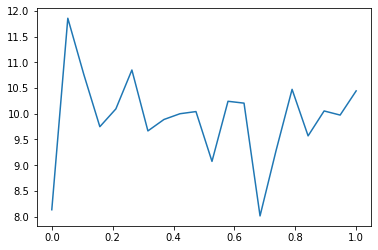

In [12]:
plt.plot(lrs,ta_epoch)

***Creating schedules of LR and momentum for final One cycle model training***
<hr>

In [13]:
lr_s = np.interp(np.arange(24), [0, 4, 23, 24], [min_lr, max_lr, min_lr, 0])
mtm_s = np.interp(np.arange(24), [0, 4, 23, 24], [0.95, 0.8, 0.95, 0.95])

print(lr_s)
print(mtm_s)

[0.00527263 0.01713605 0.02899947 0.04086289 0.05272632 0.05022875
 0.04773119 0.04523363 0.04273607 0.0402385  0.03774094 0.03524338
 0.03274582 0.03024825 0.02775069 0.02525313 0.02275557 0.02025801
 0.01776044 0.01526288 0.01276532 0.01026776 0.00777019 0.00527263]
[0.95       0.9125     0.875      0.8375     0.8        0.80789474
 0.81578947 0.82368421 0.83157895 0.83947368 0.84736842 0.85526316
 0.86315789 0.87105263 0.87894737 0.88684211 0.89473684 0.90263158
 0.91052632 0.91842105 0.92631579 0.93421053 0.94210526 0.95      ]


***Model Training***
---
<hr>

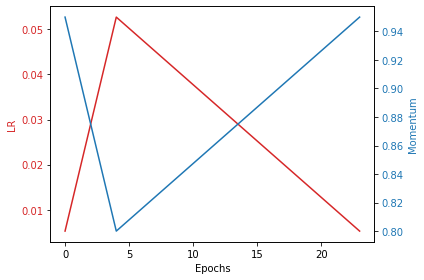

In [14]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('LR', color=color)
ax1.plot(np.arange(24), lr_s, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Momentum', color=color)
ax2.plot(np.arange(24), mtm_s, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()


# plt.plot(np.arange(24),lr_s)
# plt.plot(np.arange(24),mtm_s)

In [15]:
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
train_acc = []
train_loss = []
val_acc = []
val_loss = []


# model1 =  mfile.resnet18().to(device)
model1 =  mdl.resnet_modified_A11().to(device)
optimizer1 = optim.SGD(model1.parameters(), lr=0.1, momentum = 0.9, weight_decay=0.001)
scheduler1 = ListScheduler(optimizer1, lrs=lr_s, momentums=mtm_s)
EPOCHS = 24
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    current_lr = [g['lr'] for g in optimizer1.param_groups]
    current_m = [g['momentum'] for g in optimizer1.param_groups]
    print('LR: {}, M : {}'.format(current_lr, current_m))
    tr_ac_batch, tr_ls_batch, tr_ac_epoch, tr_ls_epoch   =  ttfunc.train(model1, device, trainloader, optimizer1, epoch)
    ts_ac, ts_ls =  ttfunc.test(model1, device, testloader, classes)
    scheduler1.step()
    print('')


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1
LR: [0.005272631578947369], M : [0.9500000000000001]


Loss=1.4652944803237915 Batch_id=97 Accuracy=35.16: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 4937/10000 (49.37%)


EPOCH: 2
LR: [0.017136052631578948], M : [0.9125]


Loss=1.1091662645339966 Batch_id=97 Accuracy=53.60: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 6638/10000 (66.38%)


EPOCH: 3
LR: [0.028999473684210533], M : [0.875]


Loss=1.1294355392456055 Batch_id=97 Accuracy=62.46: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 6852/10000 (68.52%)


EPOCH: 4
LR: [0.04086289473684211], M : [0.8375]


Loss=0.7145311236381531 Batch_id=97 Accuracy=69.09: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7403/10000 (74.03%)


EPOCH: 5
LR: [0.05272631578947369], M : [0.8]


Loss=0.7967085242271423 Batch_id=97 Accuracy=74.24: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 6956/10000 (69.56%)


EPOCH: 6
LR: [0.05022875346260389], M : [0.8078947368421053]


Loss=0.7310501933097839 Batch_id=97 Accuracy=77.94: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7816/10000 (78.16%)


EPOCH: 7
LR: [0.047731191135734076], M : [0.8157894736842105]


Loss=0.6421200633049011 Batch_id=97 Accuracy=81.21: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7951/10000 (79.51%)


EPOCH: 8
LR: [0.04523362880886427], M : [0.8236842105263158]


Loss=0.39795583486557007 Batch_id=97 Accuracy=83.23: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8427/10000 (84.27%)


EPOCH: 9
LR: [0.04273606648199446], M : [0.8315789473684211]


Loss=0.42075324058532715 Batch_id=97 Accuracy=85.16: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8418/10000 (84.18%)


EPOCH: 10
LR: [0.04023850415512466], M : [0.8394736842105264]


Loss=0.4312886595726013 Batch_id=97 Accuracy=86.04: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8530/10000 (85.30%)


EPOCH: 11
LR: [0.037740941828254854], M : [0.8473684210526315]


Loss=0.4300054907798767 Batch_id=97 Accuracy=87.25: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8539/10000 (85.39%)


EPOCH: 12
LR: [0.03524337950138505], M : [0.8552631578947368]


Loss=0.38351044058799744 Batch_id=97 Accuracy=88.29: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8494/10000 (84.94%)


EPOCH: 13
LR: [0.03274581717451524], M : [0.8631578947368421]


Loss=0.2681314945220947 Batch_id=97 Accuracy=89.12: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8623/10000 (86.23%)


EPOCH: 14
LR: [0.03024825484764543], M : [0.8710526315789474]


Loss=0.29864954948425293 Batch_id=97 Accuracy=89.62: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8802/10000 (88.02%)


EPOCH: 15
LR: [0.027750692520775624], M : [0.8789473684210526]


Loss=0.25436198711395264 Batch_id=97 Accuracy=90.63: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8798/10000 (87.98%)


EPOCH: 16
LR: [0.02525313019390582], M : [0.8868421052631579]


Loss=0.25118035078048706 Batch_id=97 Accuracy=91.30: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8822/10000 (88.22%)


EPOCH: 17
LR: [0.022755567867036013], M : [0.8947368421052632]


Loss=0.18404552340507507 Batch_id=97 Accuracy=92.09: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8902/10000 (89.02%)


EPOCH: 18
LR: [0.020258005540166206], M : [0.9026315789473686]


Loss=0.2687211334705353 Batch_id=97 Accuracy=92.53: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8831/10000 (88.31%)


EPOCH: 19
LR: [0.017760443213296402], M : [0.9105263157894736]


Loss=0.26203274726867676 Batch_id=97 Accuracy=93.06: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8924/10000 (89.24%)


EPOCH: 20
LR: [0.015262880886426591], M : [0.9184210526315789]


Loss=0.18281030654907227 Batch_id=97 Accuracy=93.79: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8956/10000 (89.56%)


EPOCH: 21
LR: [0.012765318559556788], M : [0.9263157894736842]


Loss=0.1150587722659111 Batch_id=97 Accuracy=94.52: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9010/10000 (90.10%)


EPOCH: 22
LR: [0.010267756232686984], M : [0.9342105263157895]


Loss=0.19184017181396484 Batch_id=97 Accuracy=95.07: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9065/10000 (90.65%)


EPOCH: 23
LR: [0.007770193905817173], M : [0.9421052631578948]


Loss=0.12220239639282227 Batch_id=97 Accuracy=95.62: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9107/10000 (91.07%)


EPOCH: 24
LR: [0.005272631578947369], M : [0.9500000000000001]


Loss=0.10627087205648422 Batch_id=97 Accuracy=96.36: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]



Test set: Average loss: 0.0006, Accuracy: 9140/10000 (91.40%)




In [0]:
# model

***Checking test data performance/results***
<hr>

------------------------------------------------------------
Model accuracy on 10000 test images: 91.40%
------------------------------------------------------------
 
Category   - Accuracy
plane      - 94.80
car        - 95.60
bird       - 86.20
cat        - 79.10
deer       - 94.30
dog        - 89.10
frog       - 92.80
horse      - 93.30
ship       - 92.60
truck      - 96.20
 


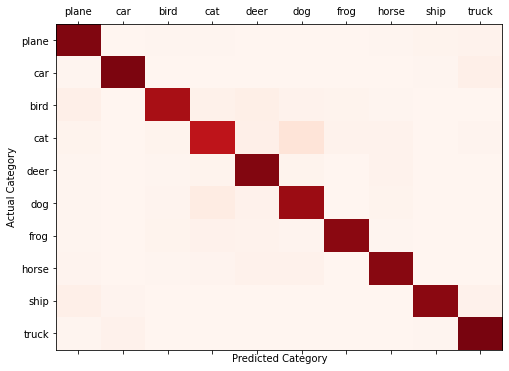

In [16]:
tperform.test_performance(model1, testloader, device, classes)

***Show misclassified TEST images***
<hr>

In [0]:
# mp.train_testplots(trainloss = tr_ls_batch , trainacc = tr_ac_batch, testloss = ts_ls , testacc = ts_ac)

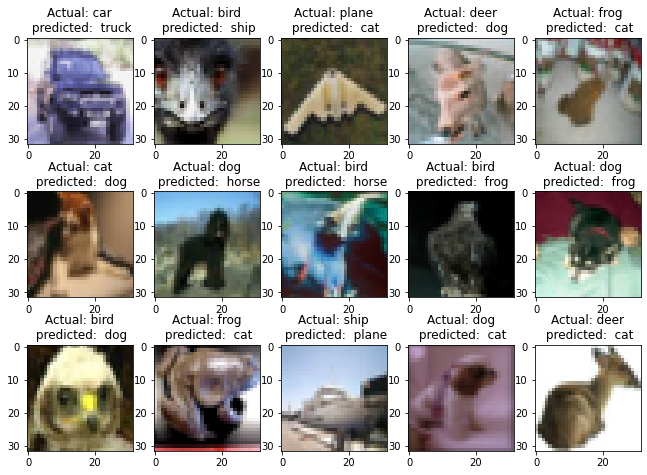

In [18]:
images, actuals, preds = misclassified.test_misclassified(model1,device,testloader)
misclassified.plot_images(images, actuals, preds, classes)